In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/yellow_tripdata_2019-06.csv


In [2]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [3]:
taxi_data = pd.read_csv('../input/yellow_tripdata_2019-06.csv')
taxi_data = taxi_data.dropna()
taxi_data.shape

(6941024, 18)

In [4]:
# Delete all the trip distance which are 0 and less
taxi_data = taxi_data[taxi_data["trip_distance"] > 0]
taxi_data = taxi_data[taxi_data["fare_amount"] > 0]
taxi_data.shape

(6865069, 18)

In [5]:
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1,4.4,1,N,74,7,2,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0,0.8,1,N,145,145,2,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1,1.7,1,N,113,148,1,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2,1.6,1,N,79,125,1,9.5,3.0,0.5,1.00,0.0,0.3,14.30,2.5
6,1,2019-06-01 00:46:46,2019-06-01 00:50:55,4,0.6,1,N,211,148,2,4.5,3.0,0.5,0.00,0.0,0.3,8.30,2.5


In [6]:
cols = [1,2,4,10]
taxi_data_final = taxi_data[taxi_data.columns[cols]]
taxi_data_final.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount
2,2019-06-01 00:17:05,2019-06-01 00:36:38,4.4,17.5
3,2019-06-01 00:59:02,2019-06-01 00:59:12,0.8,2.5
4,2019-06-01 00:03:25,2019-06-01 00:15:42,1.7,9.5
5,2019-06-01 00:28:31,2019-06-01 00:39:23,1.6,9.5
6,2019-06-01 00:46:46,2019-06-01 00:50:55,0.6,4.5


In [7]:
#taxi_data_final['Travel_time'] = pd.to_datetime(taxi_data_final['Travel_time'], format='%H:%M')
taxi_data_final['tpep_pickup_datetime'] = pd.to_datetime(taxi_data_final['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M')
taxi_data_final['tpep_dropoff_datetime'] = pd.to_datetime(taxi_data_final['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M')


In [8]:
taxi_data_final.head()

taxi_data_final.shape

(6865069, 4)

In [9]:
# Get the travel time
from datetime import datetime
taxi_data_final['Travel_time'] = taxi_data_final['tpep_dropoff_datetime'] - taxi_data_final['tpep_pickup_datetime']

taxi_data_final["Travel_time"] = pd.to_numeric(taxi_data_final['Travel_time'].dt.components["minutes"], downcast = 'integer')

In [10]:
taxi_data_final.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,Travel_time
2,2019-06-01 00:17:05,2019-06-01 00:36:38,4.4,17.5,19
3,2019-06-01 00:59:02,2019-06-01 00:59:12,0.8,2.5,0
4,2019-06-01 00:03:25,2019-06-01 00:15:42,1.7,9.5,12
5,2019-06-01 00:28:31,2019-06-01 00:39:23,1.6,9.5,10
6,2019-06-01 00:46:46,2019-06-01 00:50:55,0.6,4.5,4


In [11]:
taxi_data_final['weekday'] = taxi_data_final["tpep_pickup_datetime"].dt.dayofweek
taxi_data_final.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,Travel_time,weekday
2,2019-06-01 00:17:05,2019-06-01 00:36:38,4.4,17.5,19,5
3,2019-06-01 00:59:02,2019-06-01 00:59:12,0.8,2.5,0,5
4,2019-06-01 00:03:25,2019-06-01 00:15:42,1.7,9.5,12,5
5,2019-06-01 00:28:31,2019-06-01 00:39:23,1.6,9.5,10,5
6,2019-06-01 00:46:46,2019-06-01 00:50:55,0.6,4.5,4,5


In [12]:
taxi_data_final.loc[taxi_data_final['weekday'] == 0, 'Day'] = "Monday"
taxi_data_final.loc[taxi_data_final['weekday'] == 1, 'Day'] = "Tuesday"
taxi_data_final.loc[taxi_data_final['weekday'] == 2, 'Day'] = "Wednesday"
taxi_data_final.loc[taxi_data_final['weekday'] == 3, 'Day'] = "Thursday"
taxi_data_final.loc[taxi_data_final['weekday'] == 4, 'Day'] = "Friday"
taxi_data_final.loc[taxi_data_final['weekday'] == 5, 'Day'] = "Saturday"
taxi_data_final.loc[taxi_data_final['weekday'] == 6, 'Day'] = "Sunday"

In [13]:
taxi_data_final.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,Travel_time,weekday,Day
2,2019-06-01 00:17:05,2019-06-01 00:36:38,4.4,17.5,19,5,Saturday
3,2019-06-01 00:59:02,2019-06-01 00:59:12,0.8,2.5,0,5,Saturday
4,2019-06-01 00:03:25,2019-06-01 00:15:42,1.7,9.5,12,5,Saturday
5,2019-06-01 00:28:31,2019-06-01 00:39:23,1.6,9.5,10,5,Saturday
6,2019-06-01 00:46:46,2019-06-01 00:50:55,0.6,4.5,4,5,Saturday


In [14]:
#taxi_data.loc[taxi_data['tpep_pickup_datetime'].dt.hour >= 5, 'TimeofDay'] = 'Morning'
#taxi_data['TimeofDay'] = taxi_data['tpep_pickup_datetime'].dt.hour

taxi_data_final['TimeofDay'] = taxi_data_final['tpep_pickup_datetime'].dt.hour

taxi_data_final["HourofDay"] = np.where(((taxi_data_final.TimeofDay >= 3) & ((taxi_data_final.TimeofDay) <= 7)), "EarlyMorning",
                                np.where(((taxi_data_final.TimeofDay >= 8) & ((taxi_data_final.TimeofDay) <= 11)), "Morning",
                                 np.where(((taxi_data_final.TimeofDay >= 12) & ((taxi_data_final.TimeofDay) <= 16)), "Noon",
                                   np.where(((taxi_data_final.TimeofDay >= 17) & ((taxi_data_final.TimeofDay) <= 21)), "Evening",'Night'))))
                                    
taxi_data_final.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,Travel_time,weekday,Day,TimeofDay,HourofDay
2,2019-06-01 00:17:05,2019-06-01 00:36:38,4.4,17.5,19,5,Saturday,0,Night
3,2019-06-01 00:59:02,2019-06-01 00:59:12,0.8,2.5,0,5,Saturday,0,Night
4,2019-06-01 00:03:25,2019-06-01 00:15:42,1.7,9.5,12,5,Saturday,0,Night
5,2019-06-01 00:28:31,2019-06-01 00:39:23,1.6,9.5,10,5,Saturday,0,Night
6,2019-06-01 00:46:46,2019-06-01 00:50:55,0.6,4.5,4,5,Saturday,0,Night


In [15]:
# Now for modeling we will only consider the below columns
cols = [2,3,4,6,8]
model_data = taxi_data_final.copy()
model_data = model_data[model_data.columns[cols]]

model_data.head()

,trip_distance,fare_amount,Travel_time,Day,HourofDay
2,4.4,17.5,19,Saturday,Night
3,0.8,2.5,0,Saturday,Night
4,1.7,9.5,12,Saturday,Night
5,1.6,9.5,10,Saturday,Night
6,0.6,4.5,4,Saturday,Night


In [16]:
#######################################################Exploratory Data Analysis#########################################################################

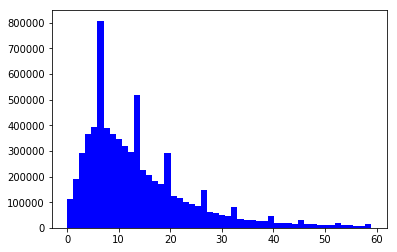

In [17]:
# View the distribution of Travel time

nbins=50
nbins,plt.hist(model_data['Travel_time'],nbins,facecolor='blue')
plt.show()

# We observe significant number of outliers

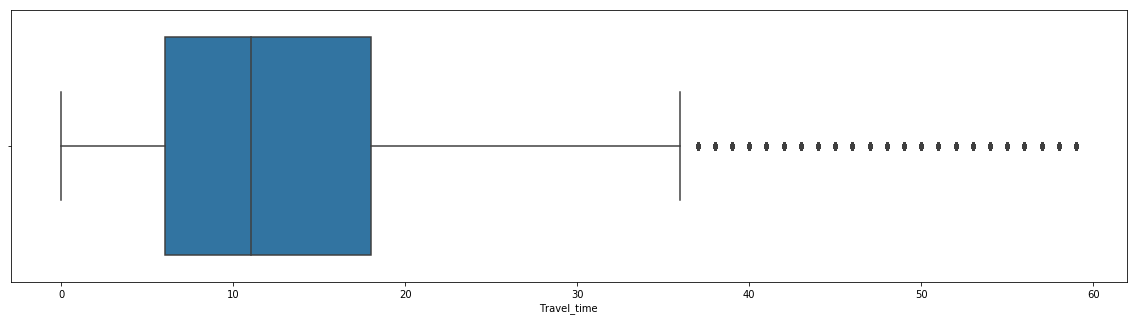

In [18]:
plt.figure(figsize = (20,5))
sns.boxplot(model_data['Travel_time'])
plt.show()



In [19]:
model_data['Travel_time'].describe()


count    6.865069e+06
mean     1.392982e+01
std      1.059709e+01
min      0.000000e+00
25%      6.000000e+00
50%      1.100000e+01
75%      1.800000e+01
max      5.900000e+01
Name: Travel_time, dtype: float64

In [20]:
model_data = model_data[model_data.Travel_time > 0]

# We observe that there are outliers, we will remove them

model_data = model_data[model_data.Travel_time < 34]



In [21]:
#from sklearn.model_selection import train_test_split

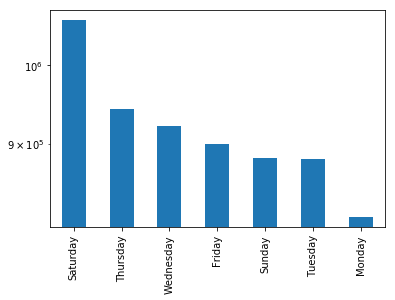

In [22]:
%matplotlib inline
model_data['Day'].value_counts().plot(kind='bar')
plt.yscale('log')
plt.show()

# Most of the travel is during Saturday and least on Monday. 

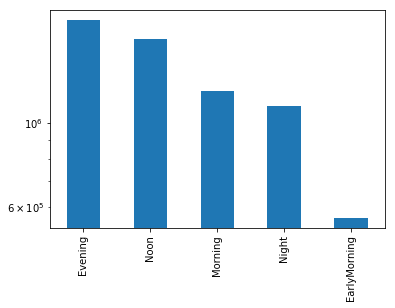

In [23]:
%matplotlib inline
model_data['HourofDay'].value_counts().plot(kind='bar')
plt.yscale('log')
plt.show()

# We observe that the travel time during early morning hours is the least and evening hours is where the time taken is very high and also during AfterNoon Hours

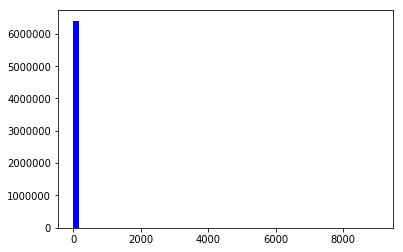

In [24]:
nbins=50
nbins,plt.hist(model_data['fare_amount'],nbins,facecolor='blue')
plt.show()

In [25]:
model_data['fare_amount'].describe()



count    6.406656e+06
mean     1.171849e+01
std      9.834603e+00
min      1.000000e-02
25%      6.500000e+00
50%      9.000000e+00
75%      1.350000e+01
max      9.022000e+03
Name: fare_amount, dtype: float64

In [26]:
# We see there are negative amount and also amount as big as 9000 which definitely is an outlier. we will remove them

model_data = model_data[model_data.fare_amount >= 1]

model_data = model_data[model_data.fare_amount <= 20]

In [27]:
model_data.shape

(5770850, 5)

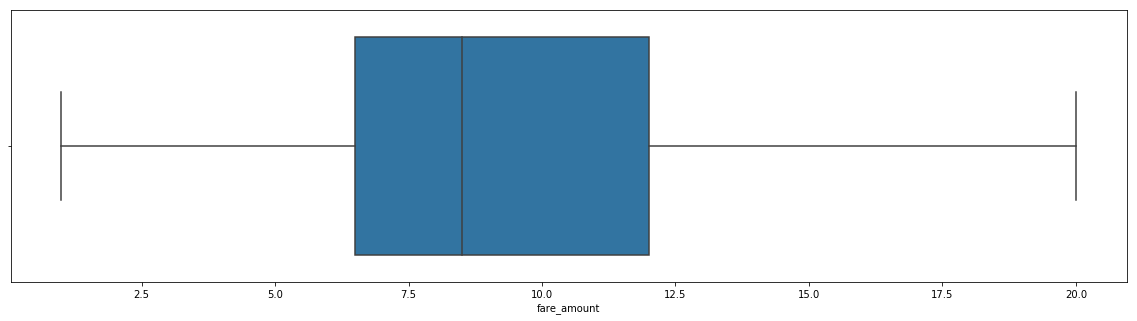

In [28]:
plt.figure(figsize = (20,5))
sns.boxplot(model_data['fare_amount'])
plt.show()

# Observation: Most

In [29]:
model_data.dtypes

trip_distance    float64
fare_amount      float64
Travel_time         int8
Day               object
HourofDay         object
dtype: object

In [30]:
corr_mat=model_data.select_dtypes(['float', 'int8']).corr()
#mask = np.zeros_like(corr_mat, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True
#f, ax = plt.subplots(figsize=(11, 9))
#cmap = sns.diverging_palette(220, 10, as_cmap=True,center="light")
#sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [31]:
corr_mat

,trip_distance,fare_amount,Travel_time
trip_distance,1.000000,0.871092,0.656211
fare_amount,0.871092,1.000000,0.932197
Travel_time,0.656211,0.932197,1.000000


In [32]:
# We see that there is a strong correlation between distance travelled, fare amount and Travel time. As is understood farther the distance more the fare, so we can remove
# Amount as there exists a multicollinearity between then

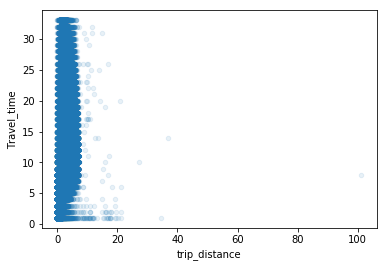

In [33]:
model_data.plot('trip_distance', 'Travel_time', kind = 'scatter', marker = 'o',alpha=.1);

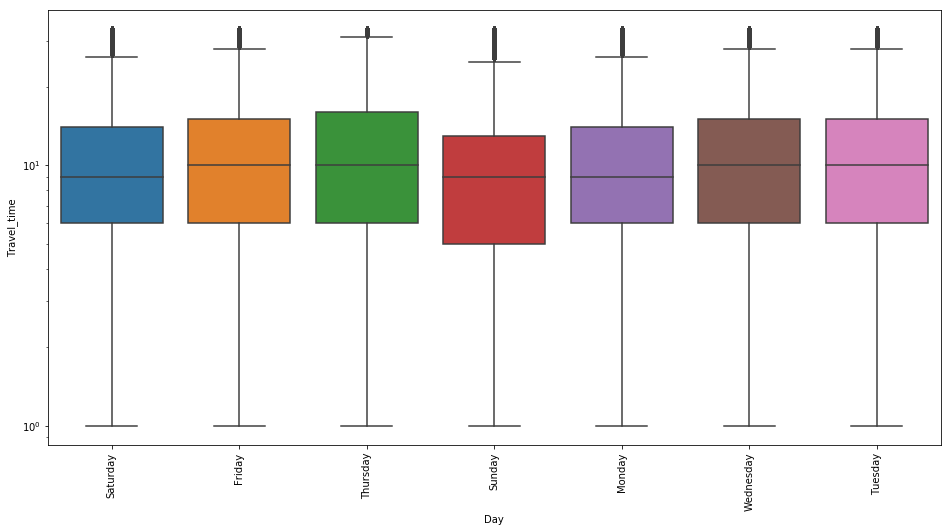

In [34]:
var = 'Day'
data = pd.concat([model_data['Travel_time'], model_data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Travel_time", data=model_data)
#fig.axis(ymin=25000
, ymax=1000000);
ax.set_yscale('log')
plt.xticks(rotation=90);

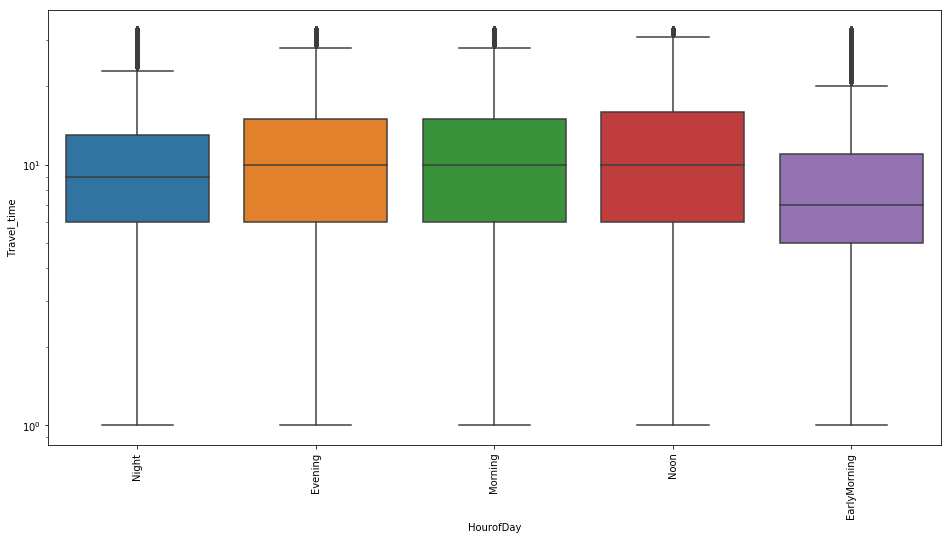

In [35]:
var = 'HourofDay'
data = pd.concat([model_data['Travel_time'], model_data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Travel_time", data=model_data)
#fig.axis(ymin=25000
, ymax=1000000);
ax.set_yscale('log')
plt.xticks(rotation=90);

In [36]:
model_data.head()

,trip_distance,fare_amount,Travel_time,Day,HourofDay
2,4.4,17.5,19,Saturday,Night
4,1.7,9.5,12,Saturday,Night
5,1.6,9.5,10,Saturday,Night
6,0.6,4.5,4,Saturday,Night
7,1.2,7.5,8,Saturday,Night


In [37]:
# We will consider the below variables for our model based on our Exploratory data analysis
# X - Variables
# 1. Distance
# 2. Day
# 3. Hour of Day

# Y- Variable
# Travel_time

In [38]:
model_data_final = model_data.copy()
cols = [0,2,3,4]

model_data_final = model_data_final[model_data_final.columns[cols]]

model_data_final.head()

,trip_distance,Travel_time,Day,HourofDay
2,4.4,19,Saturday,Night
4,1.7,12,Saturday,Night
5,1.6,10,Saturday,Night
6,0.6,4,Saturday,Night
7,1.2,8,Saturday,Night


In [39]:
model_data_final_1 =pd.get_dummies(model_data_final, drop_first = True)

In [40]:
model_data_final_1.head()

,trip_distance,Travel_time,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,HourofDay_Evening,HourofDay_Morning,HourofDay_Night,HourofDay_Noon
2,4.4,19,0,1,0,0,0,0,0,0,1,0
4,1.7,12,0,1,0,0,0,0,0,0,1,0
5,1.6,10,0,1,0,0,0,0,0,0,1,0
6,0.6,4,0,1,0,0,0,0,0,0,1,0
7,1.2,8,0,1,0,0,0,0,0,0,1,0


In [41]:
# Split data into train and test

ind = np.random.rand(len(model_data_final_1)) <= 0.7
train = model_data_final_1[ind]
test = model_data_final_1[~ind]

print("Train Data",train.shape, "Test Data",test.shape)



Train Data (4041171, 12) Test Data (1729679, 12)


In [42]:
train.head()

,trip_distance,Travel_time,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,HourofDay_Evening,HourofDay_Morning,HourofDay_Night,HourofDay_Noon
2,4.4,19,0,1,0,0,0,0,0,0,1,0
4,1.7,12,0,1,0,0,0,0,0,0,1,0
6,0.6,4,0,1,0,0,0,0,0,0,1,0
7,1.2,8,0,1,0,0,0,0,0,0,1,0
8,2.0,15,0,1,0,0,0,0,0,0,1,0


In [43]:
X_train = train.copy()
X_train.drop(['Travel_time'],axis = 1, inplace = True)
#X_train = X_train[:,-2]
Y_train = train.copy()
Y_train = Y_train.loc[:,'Travel_time']

In [44]:
X_test = test.copy()
X_test.drop(['Travel_time'],axis = 1, inplace = True)
Y_test = test.copy()
Y_test = Y_test.loc[:,'Travel_time']

In [45]:
X_train = X_train.values
Y_test = Y_test.values

In [46]:
# We will perform simulation with some data

# Get the pdf of the exponential distribution - Travel time
expon_pdf = lambda y,mu : mu * np.exp(-mu * y)

In [47]:
# Simulation Function Module
def perform_simulation(mu,travel_time):
    
    for m in mu:
        distribution = []
        for y in travel_time:
            distribution.append(expon_pdf(y,m))
        ax.plot(travel_time, 
                distribution, 
                label=f'$\mu$={mu}',
                alpha = 0.5, 
                marker = 'o', 
                markersize = 5)
    ax.grid()
    ax.set_xlabel('$y$', fontsize = 10)
    ax.set_ylabel('$f(y\mid \mu)$', fontsize = 10)
    ax.axis(xmin=0, ymin = 0)
    ax.legend(fontsize = 10)
    
    plt.show()

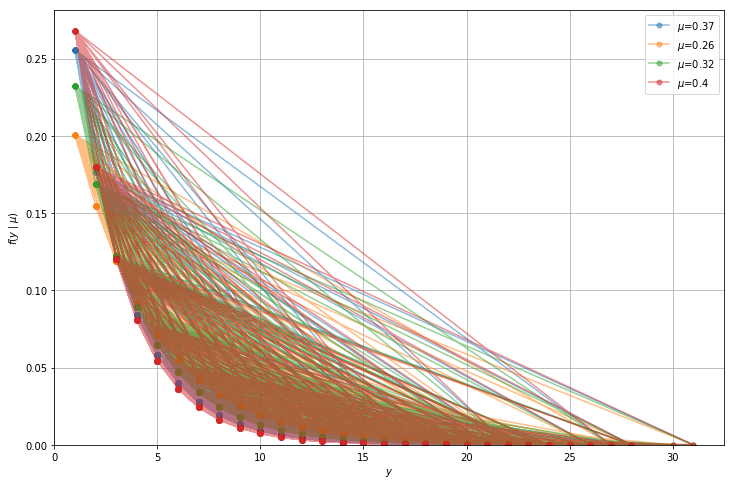

In [48]:
# Perform simulation with 1000 records
#cols = 
fig, ax = plt.subplots(figsize = (12,8))
k = np.array([0.1,0.2, 0.1, 0.1,0.1,0.1,0.1,0.1,0.1,0.1, 0.1])
# Lets take only 5 lambda values
sim_x = X_train[1:5]
sim_y = Y_train[1:1000]
for x in sim_x:
    #mu = np.exp(x @ k)
    mu = np.sum(x @ k)
    distribution = []
    for y_i in sim_y:
        distribution.append(expon_pdf(y_i,mu))
    ax.plot(sim_y, 
                distribution, 
                label=f'$\mu$={mu}',
                alpha = 0.5, 
                marker = 'o', 
                markersize = 5)
ax.grid()
ax.set_xlabel('$y$', fontsize = 10)
ax.set_ylabel('$f(y\mid \mu)$', fontsize = 10)
ax.axis(xmin=0, ymin = 0)
ax.legend(fontsize = 10)
    
plt.show()    

In [49]:
# Parameter Estimation using Maximum Likelihood

# For a exponential distribution the MLE = 


In [50]:
def mle(index):
    parameter = 1/np.mean(X_train[:,index] * Y_train)
    return parameter
    

In [51]:
# Get the Parameters using Maximum Likelihood
nvar = 11
k = np.zeros(nvar)


it = np.nditer(k, flags=['f_index'])
while not it.finished:
      #print("%d <%d>" % (it[0], it.index), end=" ")
       #print(it.index)
       k[it.index] = mle(it.index)
       it.iternext()
    



In [52]:
k

array([0.04223907, 0.74724966, 0.58081461, 0.76731979, 0.5857993 ,
       0.65653881, 0.60692687, 0.31019854, 0.46223555, 0.5992593 ,
       0.32823525])

In [53]:
yPred = np.exp( 0.09 + X_test @ k)

In [54]:
k0 = 1/np.mean(Y_train)
k0

0.09254688769467258

In [55]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(Y_test,yPred))
rms

9.94294445434324

In [56]:
from sklearn.preprocessing import StandardScaler
# Try using scaled value
scaler = StandardScaler()

X_scaled = scaler.fit_transform(model_data_final_1)
#X_test_scaled =  scaler.fit_transform(X_test)

In [57]:
# Split data into train and test

ind = np.random.rand(len(X_scaled)) <= 0.7
train = X_scaled[ind]
test = X_scaled[~ind]

print("Train Data",train.shape, "Test Data",test.shape)

Train Data (4037675, 12) Test Data (1733175, 12)


In [58]:
Y_train = train[:,1]
Y_train

array([ 1.29914136,  0.18931369, -0.12777994, ..., -0.76196718,
       -0.60342037, -0.92051399])

In [59]:
X_train = np.delete(train,1,1)
X_train
#Given its name, I think the standard way should be delete:

#import numpy as np

#A = np.delete(A, 1, 0)  # delete second row of A
#B = np.delete(B, 2, 0)  # delete third row of B
#C = np.delete(C, 1, 1)

array([[ 2.32382441, -0.38072531,  2.23140822, ..., -0.48752516,
         2.23663634, -0.5968774 ],
       [-0.04867853, -0.38072531,  2.23140822, ..., -0.48752516,
         2.23663634, -0.5968774 ],
       [-0.13654901, -0.38072531,  2.23140822, ..., -0.48752516,
         2.23663634, -0.5968774 ],
       ...,
       [-1.10312428, -0.38072531, -0.44814749, ..., -0.48752516,
         2.23663634, -0.5968774 ],
       [-0.32986406, -0.38072531, -0.44814749, ..., -0.48752516,
         2.23663634, -0.5968774 ],
       [ 0.01283081, -0.38072531, -0.44814749, ..., -0.48752516,
         2.23663634, -0.5968774 ]])

In [60]:
def mle_scaled(index):
    parameter = 1/np.mean(X_train[:,index] * Y_train)
    return parameter

In [61]:
# Get the Parameters using Maximum Likelihood
nvar = 11
k = np.zeros(nvar)


it = np.nditer(k, flags=['f_index'])
while not it.finished:
      #print("%d <%d>" % (it[0], it.index), end=" ")
       #print(it.index)
       k[it.index] = mle_scaled(it.index)
       it.iternext()
k

array([  1.52408513, -74.2331068 , -27.64247771, -13.95241994,
        19.96298661,  79.66040569,  25.89852488,  88.04014369,
        27.03759979, -17.82475708,  13.39872673])

In [62]:
X_test = np.delete(test,1,1)
X_test.shape
k.shape

(11,)

In [63]:
Y_test = test[:,1]
Y_test

array([ 0.82350093, -0.76196718,  0.66495412, ...,  0.66495412,
        0.82350093, -1.39615442])

In [64]:
yPred = np.exp(X_test @ k)

In [65]:
yPred

array([3.35118122e-84, 1.05742126e-86, 1.31240096e-84, ...,
       2.41838333e-72, 2.76494671e-72, 1.08281781e-72])

In [66]:
rms = sqrt(mean_squared_error(Y_test,yPred))
rms

inf